In [1]:
import anndata
import numpy as np

from IPython.display import display
import pandas as pd
import urllib.request

from scegot import scEGOT

from pathlib import Path


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/data1/home/jyj/miniconda3/envs/gtra_bench/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/data1/home/jyj/miniconda3/envs/gtra_bench/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/data1/home/jyj/miniconda3/envs/gtra_bench/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/data1/home/jyj/miniconda3/envs/gtra_bench/lib/python3.9/site-packages/traitlets/con

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/data1/home/jyj/miniconda3/envs/gtra_bench/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/data1/home/jyj/miniconda3/envs/gtra_bench/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/data1/home/jyj/miniconda3/envs/gtra_bench/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/data1/home/jyj/miniconda3/envs/gtra_bench/lib/python3.9/site-packages/traitlets/con

AttributeError: _ARRAY_API not found

/data1/home/jyj/miniconda3/envs/gtra_bench/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
DATA_PATH = Path("/data3/projects/2025_GTRA/data/1_MND/")
dat = anndata.read_h5ad(DATA_PATH / "CCTSD_preproc_hvg.h5ad")

In [6]:
counts = dat.to_df(layer="counts")
input_data = anndata.AnnData(counts, obs=dat.obs, var=dat.var)


In [7]:
time_order = ["e11", "e13", "e15", "e17"]
input_data.obs["Time_points"] = pd.Categorical(
    input_data.obs["Time_points"], 
    categories=time_order, 
    ordered=True)

In [8]:
input_data = input_data[input_data.obs["Time_points"].cat.codes.argsort()]

In [9]:
scegot = scEGOT(
    input_data,
    verbose=True,  # default=True
    adata_day_key="Time_points",
)

Processing AnnData...


In [10]:
RANDOM_STATE = 2023
PCA_N_COMPONENTS = 30
GMM_CLUSTER_NUMBERS = [7, 7, 7, 7]
UMAP_N_NEIGHBORS = 1000
DAY_NAMES = ["E11", "E13", "E15", "E17"]


In [11]:
%%time
X, pca_model = scegot.preprocess(
    PCA_N_COMPONENTS,
    recode_params={},
    umi_target_sum=1e5,
    pca_random_state=RANDOM_STATE,
    pca_other_params={},
    apply_recode=True,
    apply_normalization_log1p=True,
    apply_normalization_umi=True,
    select_genes=False,
    # n_select_genes=2000,
)

Applying RECODE...
start RECODE for scRNA-seq data
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': np.int64(1946), '#non-significant genes': np.int64(54), '#silent genes': np.int64(0), 'ell': np.int64(268), 'Elapsed time': '0h 0m 6s 566ms', 'solver': 'full'}
Applying UMI normalization...
Applying log1p normalization...
Applying PCA...
	sum of explained_variance_ratio = 29.83596530842442
CPU times: user 7min 12s, sys: 9.77 s, total: 7min 22s
Wall time: 7.26 s


In [12]:
%%time
# scegot.day_names = [11,13,15,17]

gmm_models, gmm_labels = scegot.fit_predict_gmm(
    n_components_list=GMM_CLUSTER_NUMBERS,
    covariance_type="full",
    max_iter=2000,
    n_init=10,
    random_state=RANDOM_STATE,
    gmm_other_params={},
)

Fitting GMM models with each day's data and predicting labels for them...


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:06<00:00,  1.67s/it]

CPU times: user 5min 12s, sys: 788 ms, total: 5min 13s
Wall time: 6.7 s


In [13]:
%%time
X_umap, umap_model = scegot.apply_umap(
    UMAP_N_NEIGHBORS,
    n_components=2,
    random_state=RANDOM_STATE,
    min_dist=0.8,
    umap_other_params={},
)

CPU times: user 1min 55s, sys: 1.7 s, total: 1min 56s
Wall time: 1min 45s


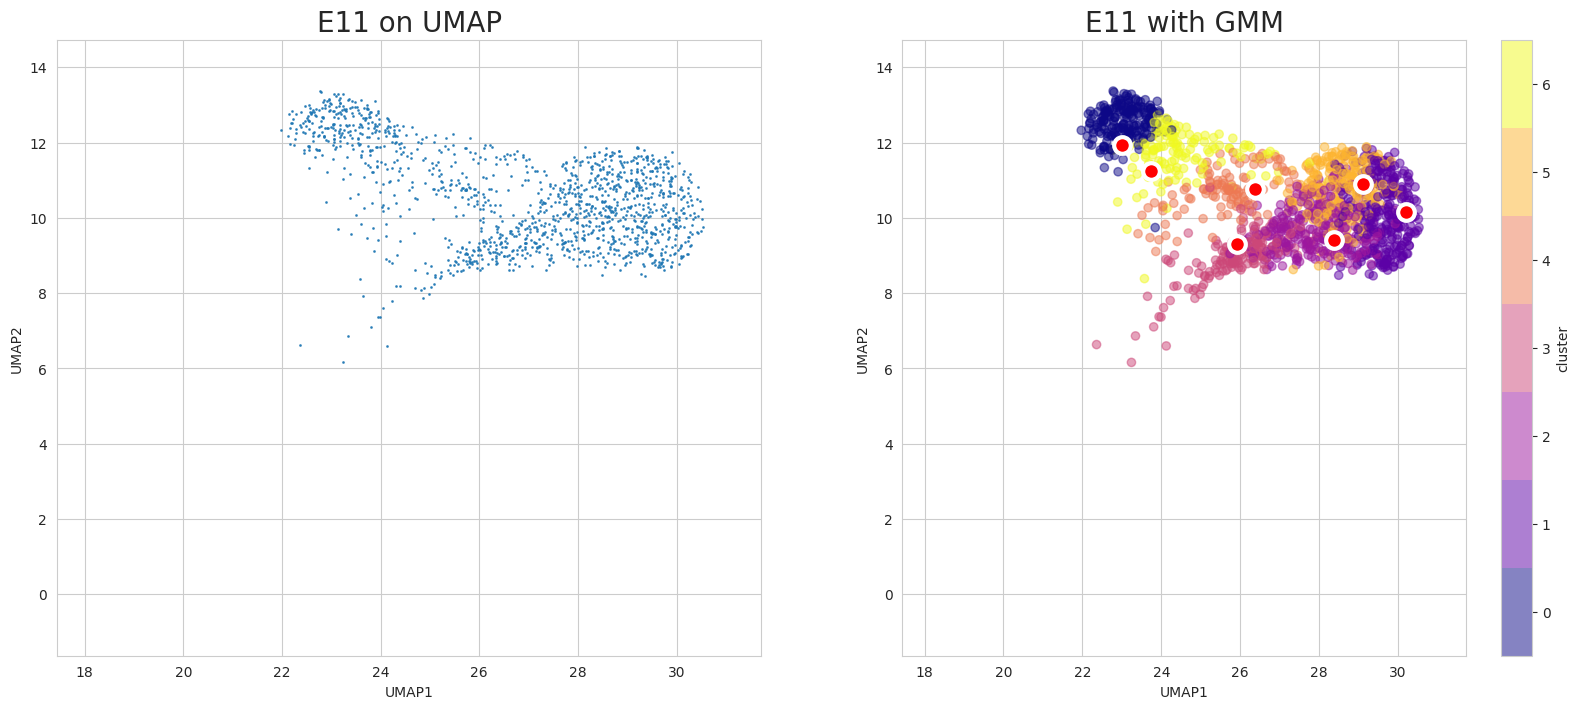

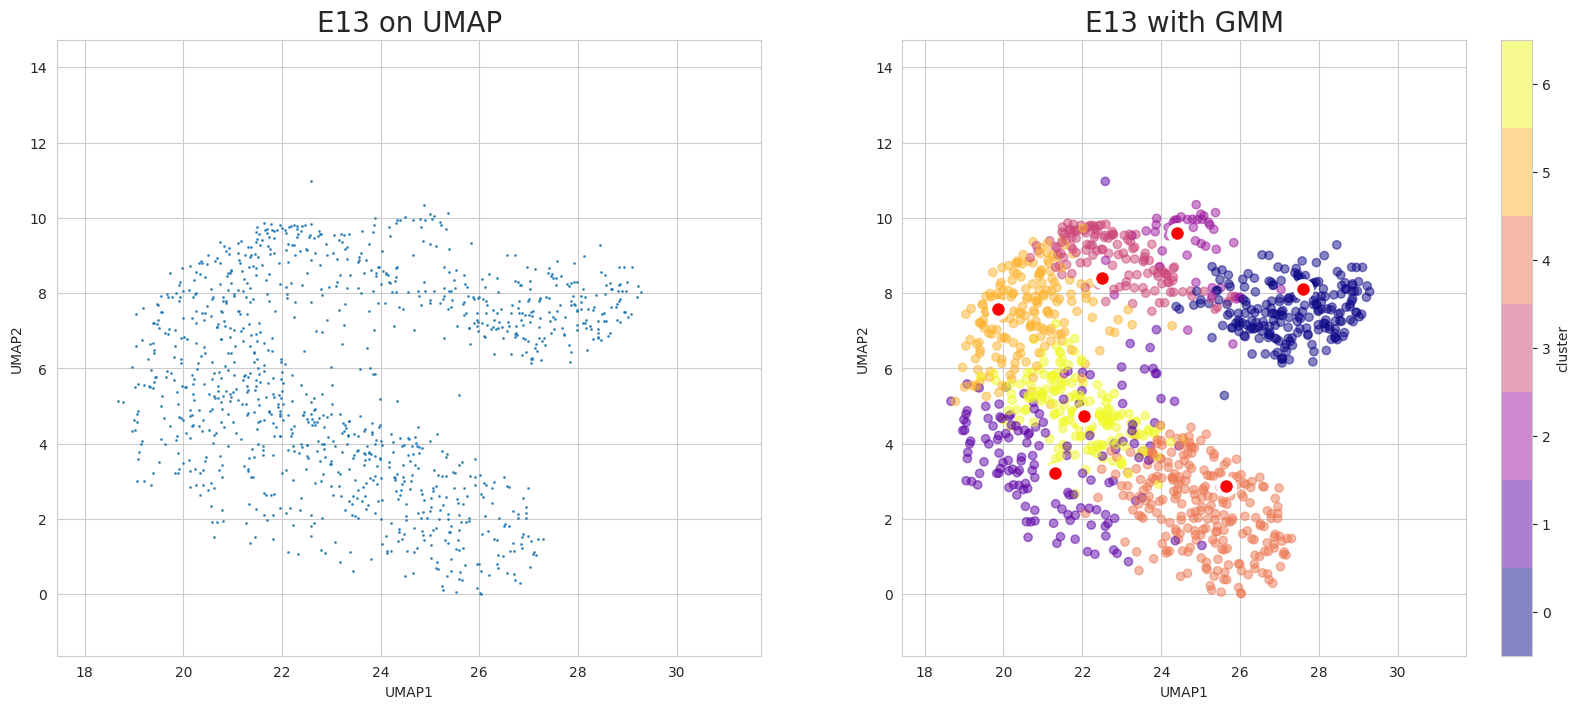

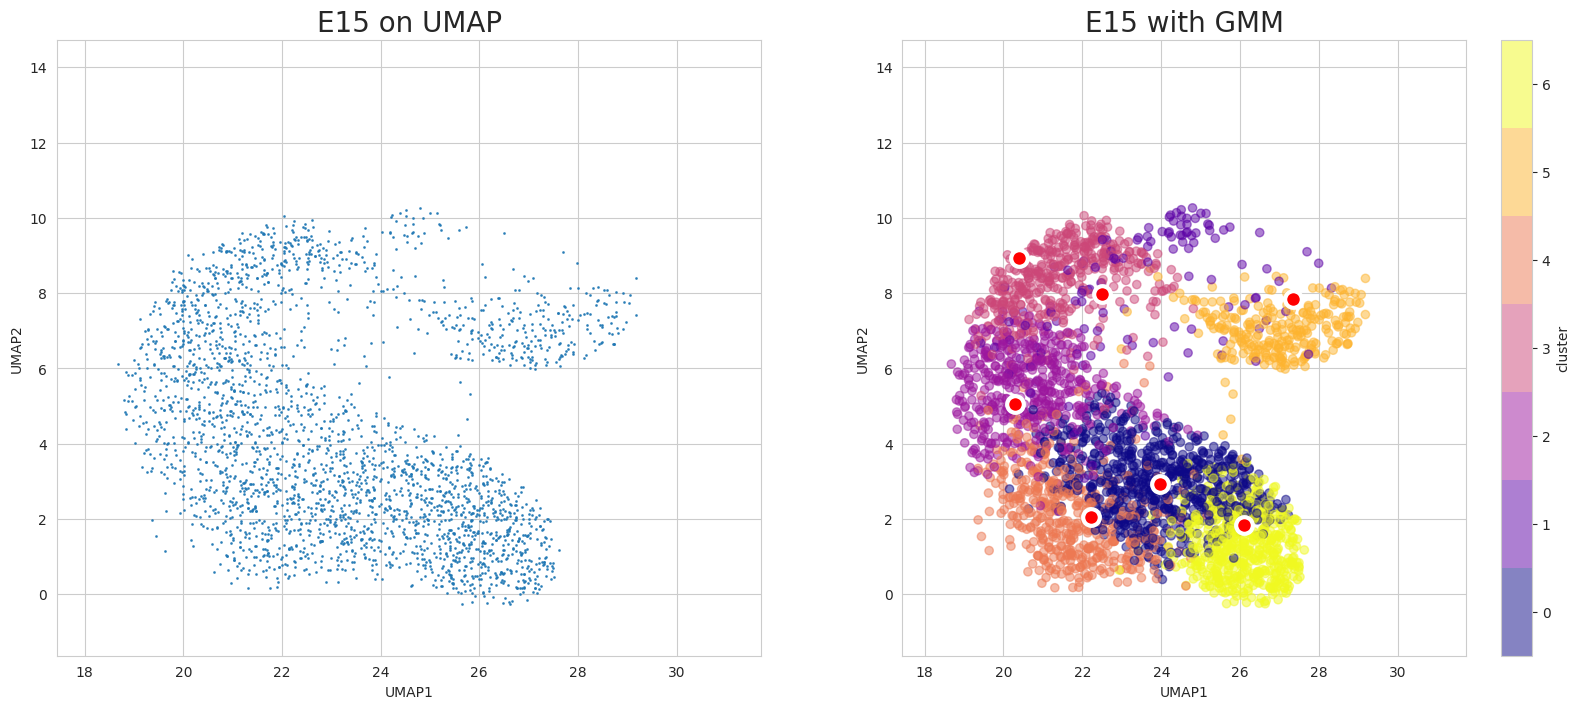

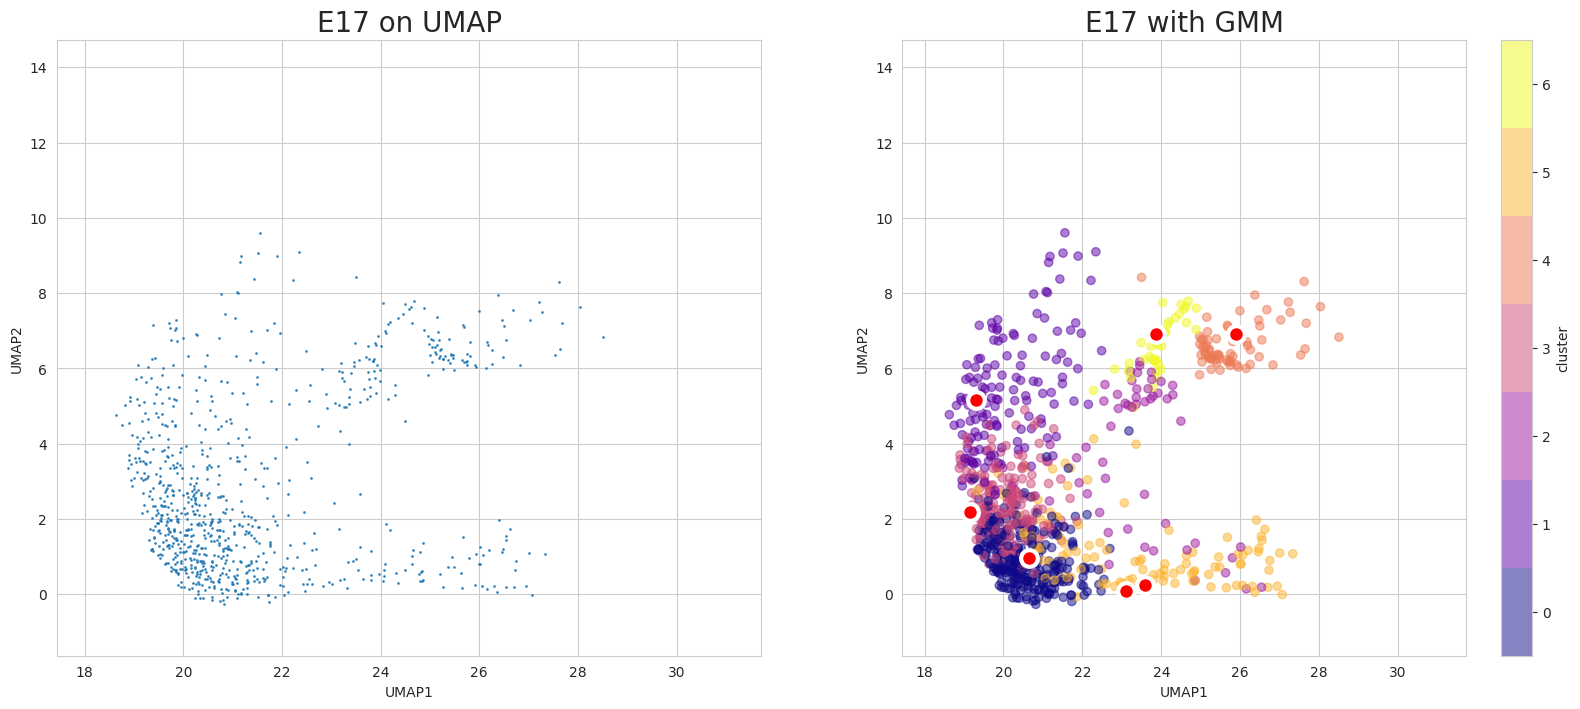

In [14]:
scegot.plot_gmm_predictions(
    mode="umap",
    plot_gmm_means=True,
    figure_titles_without_gmm=[f"{name} on UMAP" for name in DAY_NAMES],
    figure_titles_with_gmm=[f"{name} with GMM" for name in DAY_NAMES],
    cmap="plasma",
    # save=True,
    # save_paths=[f"./gmm_preds_{day_name}.png" for day_name in DAY_NAMES]
)

In [15]:
import pandas as pd

all_label_df = []

# scEGOT 내부 데이터 순회
for (tp,X_t), labels in zip(zip(DAY_NAMES,scegot.X_selected), gmm_labels):
    # 해당 시점의 셀 ID 리스트
    cell_ids = X_t.index.tolist()
    
    # label과 셀 ID 매핑
    tmp = pd.DataFrame({
        "cellid": cell_ids,
        "scegot_GMM": labels,
        "timepoints":tp
    })
    
    # 원래 input_data.obs에서 cell type 등 메타데이터 병합
    tmp = tmp.merge(
        input_data.obs.loc[cell_ids, ["cell_type", "cell_type2"]].reset_index(),
        left_on="cellid",
        right_on="index",
        how="left"
    ).drop(columns=["index"])
    
    all_label_df.append(tmp)

# 모든 시점 결합
all_label_df = pd.concat(all_label_df, ignore_index=True)

# ✅ 결과 확인


In [16]:
all_label_df[(all_label_df["timepoints"] == "E11")&
             (all_label_df["scegot_GMM"] == 6)]["cell_type2"].value_counts()

cell_type2
4-IPs              70
6-Young neurons    33
3-APs/RPs          26
1-Neurons          12
2-Young neurons     2
5-APs/RPs           0
7-IPs               0
Name: count, dtype: int64

In [17]:
all_label_df[(all_label_df["timepoints"] == "E13")&
             (all_label_df["scegot_GMM"] == 5)]["cell_type2"].value_counts()

cell_type2
4-IPs              156
6-Young neurons     15
1-Neurons            5
3-APs/RPs            2
2-Young neurons      0
5-APs/RPs            0
7-IPs                0
Name: count, dtype: int64

In [18]:
all_label_df[(all_label_df["timepoints"] == "E15")&
             (all_label_df["scegot_GMM"] == 2)]["cell_type2"].value_counts()

cell_type2
4-IPs              216
1-Neurons          168
6-Young neurons     70
2-Young neurons      7
3-APs/RPs            0
5-APs/RPs            0
7-IPs                0
Name: count, dtype: int64

In [19]:
all_label_df[(all_label_df["timepoints"] == "E17")&
             (all_label_df["scegot_GMM"] == 3)]["cell_type2"].value_counts()

cell_type2
1-Neurons          144
4-IPs               26
6-Young neurons      9
2-Young neurons      4
3-APs/RPs            0
5-APs/RPs            0
7-IPs                0
Name: count, dtype: int64

In [20]:
cluster_names = scegot.generate_cluster_names_with_day()
cluster_names

[['e11-0', 'e11-1', 'e11-2', 'e11-3', 'e11-4', 'e11-5', 'e11-6'],
 ['e13-0', 'e13-1', 'e13-2', 'e13-3', 'e13-4', 'e13-5', 'e13-6'],
 ['e15-0', 'e15-1', 'e15-2', 'e15-3', 'e15-4', 'e15-5', 'e15-6'],
 ['e17-0', 'e17-1', 'e17-2', 'e17-3', 'e17-4', 'e17-5', 'e17-6']]

In [21]:
G = scegot.make_cell_state_graph(
    cluster_names,
    mode="pca",
    threshold=0.5,
)
G_umap = scegot.make_cell_state_graph(
    cluster_names,
    mode="umap",
    threshold=0.5,
)

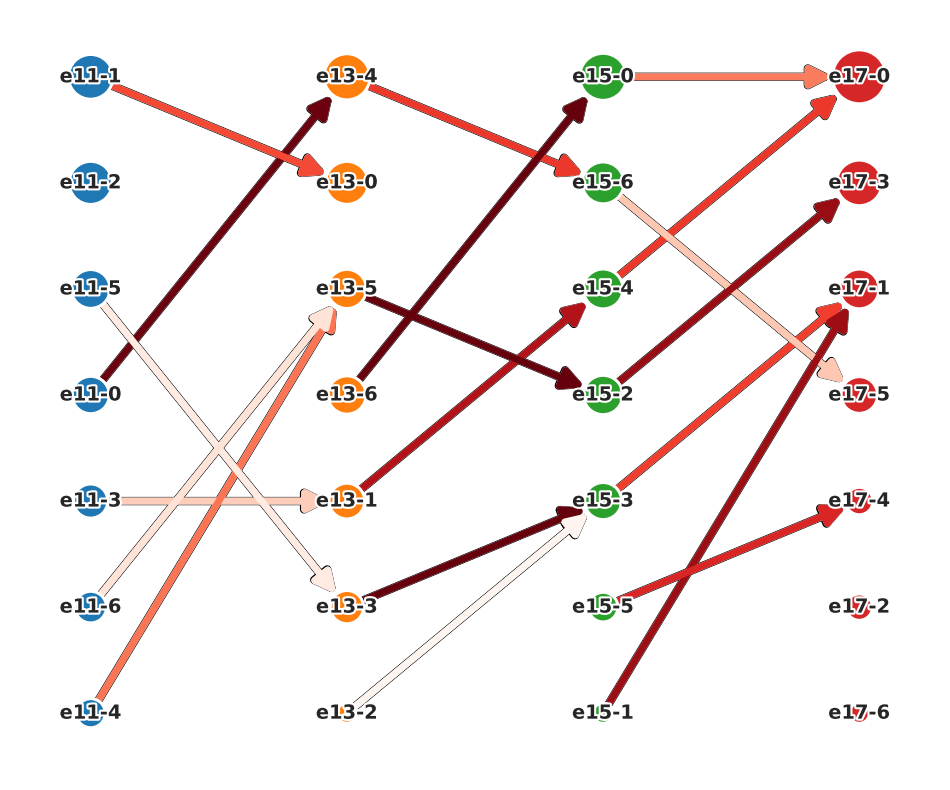

In [23]:
scegot.plot_simple_cell_state_graph(
    G_umap,
    layout="hierarchy",
    order="weight",
    # save=True,
    # save_path="./simple_cell_state_graph_hierarchy.png"
)

In [24]:
import networkx as nx

# G는 이미 weight>=0.5 로 필터링된 그래프

paths = []
for start in [n for n in G.nodes if str(n).startswith("e11")]:
    for end in [n for n in G.nodes if str(n).startswith("e17")]:
        for p in nx.all_simple_paths(G, source=start, target=end):
            paths.append(p)

print(f"Found {len(paths)} candidate paths")
for i, p in enumerate(paths):
    print(f"Path {i+1}: {' → '.join(p)}")


Found 5 candidate paths
Path 1: e11-0 → e13-4 → e15-6 → e17-5
Path 2: e11-3 → e13-1 → e15-4 → e17-0
Path 3: e11-4 → e13-5 → e15-2 → e17-3
Path 4: e11-5 → e13-3 → e15-3 → e17-1
Path 5: e11-6 → e13-5 → e15-2 → e17-3


In [152]:
cluster1 = "e11-0"
cluster2 = "e13-4"
scegot.plot_fold_change(
    cluster_names,
    cluster1,
    cluster2,
    threshold=1,
    # save=True,
    # save_path="./fold_change.png"
)

In [25]:
# edge list 추출 — weight, similarity, score 등 자동 감지
edges = []
for u, v, d in G.edges(data=True):
    # 가능한 키 중 존재하는 걸 우선 사용
    weight = d.get("edge_weights") or d.get("similarity") or d.get("score") or 1.0
    edges.append((u, v, weight))

import pandas as pd
edge_df = pd.DataFrame(edges, columns=["source_cluster", "target_cluster", "weight"])
edge_df.head()



source_cluster target_cluster    weight
0          e11-0          e13-4  0.995879
1          e13-4          e15-6  0.821823
2          e11-1          e13-0  0.798770
3          e11-3          e13-1  0.601793
4          e13-1          e15-4  0.916929

In [26]:
edge_df.sort_values("weight",ascending=False)

source_cluster target_cluster    weight
6           e13-5          e15-2  0.999980
8           e13-3          e15-3  0.999614
15          e13-6          e15-0  0.999149
0           e11-0          e13-4  0.995879
14          e15-2          e17-3  0.951318
17          e15-1          e17-1  0.947617
4           e13-1          e15-4  0.916929
18          e15-5          e17-4  0.853555
1           e13-4          e15-6  0.821823
10          e15-4          e17-0  0.821563
12          e15-3          e17-1  0.812310
2           e11-1          e13-0  0.798770
5           e11-4          e13-5  0.739038
16          e15-0          e17-0  0.726796
13          e15-6          e17-5  0.612896
3           e11-3          e13-1  0.601793
9           e11-6          e13-5  0.565022
7           e11-5          e13-3  0.539665
11          e13-2          e15-3  0.509594

In [29]:
all_label_df

cellid  scegot_GMM timepoints      cell_type       cell_type2
0     GTTCGTACCGCC           0        E11        Neurons        1-Neurons
1     GTTGAGAGTGTC           2        E11        APs/RPs        3-APs/RPs
2     GCACGCCCCAAA           2        E11        APs/RPs        3-APs/RPs
3     CAGTAGTATCGA           5        E11        APs/RPs        3-APs/RPs
4     CGTACAATTGAT           6        E11            IPs            4-IPs
...            ...         ...        ...            ...              ...
6311  GTGCGCAATCCG           5        E17  Young neurons  2-Young neurons
6312  CCTTGAACCCAC           2        E17  Young neurons  2-Young neurons
6313  AACCTAGTCATC           3        E17        Neurons        1-Neurons
6314  TCAAGTGAACCT           3        E17        Neurons        1-Neurons
6315  TATACTCCGAAC           6        E17        APs/RPs        3-APs/RPs

[6316 rows x 5 columns]

In [46]:
df = edge_df.copy()

# --- allowed transitions ---
allowed = {
    "APs/RPs": {"APs/RPs", "IPs", "Young neurons", "Neurons"},
    "IPs": {"IPs", "Young neurons", "Neurons"},
    "Young neurons": {"Young neurons", "Neurons"},
    "Neurons": {"Neurons"},
}

# --- 보조 label dataframe (timepoints, scegot_GMM, cell_type2) ---
# 예시: all_label_df

# === 1️⃣ 각 cluster의 major cell type 찾기 ===
def get_major_type(tp, clust):
    subset = all_label_df[
        (all_label_df["timepoints"] == tp.upper()) &
        (all_label_df["scegot_GMM"] == int(clust))
    ]
    if subset.empty:
        return None
    return subset["cell_type2"].value_counts().idxmax()

# === 2️⃣ transition dataframe에 source/target 시점 & cluster 분리 ===
df[["src_tp", "src_clust"]] = df["source_cluster"].str.extract(r"e(\d+)-(\d+)")
df[["tgt_tp", "tgt_clust"]] = df["target_cluster"].str.extract(r"e(\d+)-(\d+)")
df["src_tp"] = "E" + df["src_tp"].astype(str)
df["tgt_tp"] = "E" + df["tgt_tp"].astype(str)


def get_type(name):
    for t in allowed.keys():
        if t in name:
            return t
    return None

df["src_type"] = df.apply(lambda r: get_major_type(r["src_tp"], r["src_clust"]), axis=1)
df["tgt_type"] = df.apply(lambda r: get_major_type(r["tgt_tp"], r["tgt_clust"]), axis=1)

df["src_type2"] = df["src_type"].apply(get_type)
df["tgt_type2"] = df["tgt_type"].apply(get_type)


# === 4️⃣ transition 유효성 평가 ===
df["is_correct"] = df.apply(
    lambda r: r["tgt_type2"] in allowed.get(r["src_type2"], set()), axis=1
)

# === 5️⃣ F1 계산 ===
TP = df["is_correct"].sum()
FP = (~df["is_correct"]).sum()
FN = 0  # 모든 transition을 예측했다고 가정 (FN 없음)
precision = TP / (TP + FP)
recall = TP / (TP + FN + 1e-9)
f1 = 2 * precision * recall / (precision + recall + 1e-9)

print(f"TP={TP}, FP={FP}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

TP=17, FP=2, Precision=0.895, Recall=1.000, F1=0.944


In [47]:
df

source_cluster target_cluster    weight src_tp src_clust tgt_tp tgt_clust  \
0           e11-0          e13-4  0.995879    E11         0    E13         4   
1           e13-4          e15-6  0.821823    E13         4    E15         6   
2           e11-1          e13-0  0.798770    E11         1    E13         0   
3           e11-3          e13-1  0.601793    E11         3    E13         1   
4           e13-1          e15-4  0.916929    E13         1    E15         4   
5           e11-4          e13-5  0.739038    E11         4    E13         5   
6           e13-5          e15-2  0.999980    E13         5    E15         2   
7           e11-5          e13-3  0.539665    E11         5    E13         3   
8           e13-3          e15-3  0.999614    E13         3    E15         3   
9           e11-6          e13-5  0.565022    E11         6    E13         5   
10          e15-4          e17-0  0.821563    E15         4    E17         0   
11          e13-2          e15-3  0.509594    E13         2    E15         3   
12          e15-3          e17-1  0.812310    E15         3    E17         1   
13          e15-6          e17-5  0.612896    E15         6    E17         5   
14          e15-2          e17-3  0.951318    E15         2    E17         3   
15          e13-6          e15-0  0.999149    E13         6    E15         0   
16          e15-0          e17-0  0.726796    E15         0    E17         0   
17          e15-1          e17-1  0.947617    E15         1    E17         1   
18          e15-5          e17-4  0.853555    E15         5    E17         4   

           src_type         tgt_type      src_type2      tgt_type2  is_correct  
0         1-Neurons  2-Young neurons        Neurons  Young neurons       False  
1   2-Young neurons  2-Young neurons  Young neurons  Young neurons        True  
2         5-APs/RPs        3-APs/RPs        APs/RPs        APs/RPs        True  
3         3-APs/RPs        1-Neurons        APs/RPs        Neurons        True  
4         1-Neurons        1-Neurons        Neurons        Neurons        True  
5             4-IPs            4-IPs            IPs            IPs        True  
6             4-IPs            4-IPs            IPs            IPs        True  
7         3-APs/RPs            4-IPs        APs/RPs            IPs        True  
8             4-IPs            4-IPs            IPs            IPs        True  
9             4-IPs            4-IPs            IPs            IPs        True  
10        1-Neurons        1-Neurons        Neurons        Neurons        True  
11            7-IPs            4-IPs            IPs            IPs        True  
12            4-IPs            4-IPs            IPs            IPs        True  
13  2-Young neurons  2-Young neurons  Young neurons  Young neurons        True  
14            4-IPs        1-Neurons            IPs        Neurons        True  
15        1-Neurons  2-Young neurons        Neurons  Young neurons       False  
16  2-Young neurons        1-Neurons  Young neurons        Neurons        True  
17            4-IPs            4-IPs            IPs            IPs        True  
18        3-APs/RPs        3-APs/RPs        APs/RPs        APs/RPs        True

In [28]:
df

source_cluster target_cluster    weight src_tp src_clust tgt_tp tgt_clust  \
0           e11-0          e13-4  0.995879    E11         0    E13         4   
1           e13-4          e15-6  0.821823    E13         4    E15         6   
2           e11-1          e13-0  0.798770    E11         1    E13         0   
3           e11-3          e13-1  0.601793    E11         3    E13         1   
4           e13-1          e15-4  0.916929    E13         1    E15         4   
5           e11-4          e13-5  0.739038    E11         4    E13         5   
6           e13-5          e15-2  0.999980    E13         5    E15         2   
7           e11-5          e13-3  0.539665    E11         5    E13         3   
8           e13-3          e15-3  0.999614    E13         3    E15         3   
9           e11-6          e13-5  0.565022    E11         6    E13         5   
10          e15-4          e17-0  0.821563    E15         4    E17         0   
11          e13-2          e15-3  0.509594    E13         2    E15         3   
12          e15-3          e17-1  0.812310    E15         3    E17         1   
13          e15-6          e17-5  0.612896    E15         6    E17         5   
14          e15-2          e17-3  0.951318    E15         2    E17         3   
15          e13-6          e15-0  0.999149    E13         6    E15         0   
16          e15-0          e17-0  0.726796    E15         0    E17         0   
17          e15-1          e17-1  0.947617    E15         1    E17         1   
18          e15-5          e17-4  0.853555    E15         5    E17         4   

           src_type         tgt_type  is_correct  
0         1-Neurons  2-Young neurons       False  
1   2-Young neurons  2-Young neurons       False  
2         5-APs/RPs        3-APs/RPs       False  
3         3-APs/RPs        1-Neurons       False  
4         1-Neurons        1-Neurons       False  
5             4-IPs            4-IPs       False  
6             4-IPs            4-IPs       False  
7         3-APs/RPs            4-IPs       False  
8             4-IPs            4-IPs       False  
9             4-IPs            4-IPs       False  
10        1-Neurons        1-Neurons       False  
11            7-IPs            4-IPs       False  
12            4-IPs            4-IPs       False  
13  2-Young neurons  2-Young neurons       False  
14            4-IPs        1-Neurons       False  
15        1-Neurons  2-Young neurons       False  
16  2-Young neurons        1-Neurons       False  
17            4-IPs            4-IPs       False  
18        3-APs/RPs        3-APs/RPs       False

In [ ]:
scegot.cluster_names

In [144]:
cluster_names

[['e11-0', 'e11-1', 'e11-2', 'e11-3', 'e11-4', 'e11-5', 'e11-6'],
 ['e13-0', 'e13-1', 'e13-2', 'e13-3', 'e13-4', 'e13-5', 'e13-6'],
 ['e15-0', 'e15-1', 'e15-2', 'e15-3', 'e15-4', 'e15-5', 'e15-6'],
 ['e17-0', 'e17-1', 'e17-2', 'e17-3', 'e17-4', 'e17-5', 'e17-6']]

In [146]:
genes = scegot.get_positive_gmm_mean_gene_values_per_cluster(scegot.get_gmm_means(),cluster_names=list(itertools.chain.from_iterable((cluster_names))))

In [147]:
pathway_genes = genes.loc[pathway_names]

In [148]:
pathway_genes

Secisbp2l   Tubgcp5     Csmd2      Gcc2     Cep76       Ezr      Hopx  \
e11-4   3.849691  2.569794  0.895135  2.854608  2.238388  4.415526  1.730607   
e13-5   3.466057  2.550131  1.126953  3.580062  1.680544  4.611417  1.230673   
e15-2   3.656426  2.419364  1.136826  3.488968  1.247974  3.901102  1.285053   
e17-3   3.572801  2.459288  1.425307  3.473600  1.238191  2.873202  1.204849   

        Fam193b      Sdk2     Eif5b  ...  2810474O19Rik   Cacna1d    Antxr2  \
e11-4  2.689318  0.950347  5.569126  ...       3.433794  0.944589  1.423235   
e13-5  2.389506  0.708750  4.876576  ...       3.895313  1.376335  1.618341   
e15-2  2.491326  0.788602  4.999189  ...       3.721600  1.652070  1.337453   
e17-3  2.626456  0.983771  5.073213  ...       2.644318  1.939780  0.946430   

          Mast1    Il10rb     Cdca8    Lrrc24     Rnf32       Mt2    Srgap3  
e11-4  1.448556  0.817836  5.562889  0.988287  1.778030  2.829027  2.267006  
e13-5  1.609387  0.726205  2.030662  0.948869  1.683358  1.774470  2.676625  
e15-2  2.020980  0.678433  1.948234  1.209524  2.307459  1.963207  2.720144  
e17-3  2.434160  0.675341  1.679433  1.799055  2.508324  1.862911  2.984741  

[4 rows x 2000 columns]

In [140]:
pathway_names = [
    "e11-4",
    "e13-5",
    "e15-2",
    "e17-3"
]
scegot.plot_pathway_mean_var(
    cluster_names,
    pathway_names,
    # tf_gene_names=tf_gene_names,
    threshold=1,
    # save=True,
    # save_path="./pathway_mean_var.png"
)

In [127]:

selected_genes = ["Neurod2", "Neurod6", "Crabp2", "Ccnd1"]
scegot.plot_pathway_gene_expressions(
    cluster_names,
    pathway_names,
    selected_genes,
    # save=True,
    # save_path="./pathway_gene_expressions.png"
)

Calculating cell velocities between each day...


100%|██████████| 3/3 [00:00<00:00,  9.72it/s]


computing velocity graph (using 1/160 cores)


  0%|          | 0/5453 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


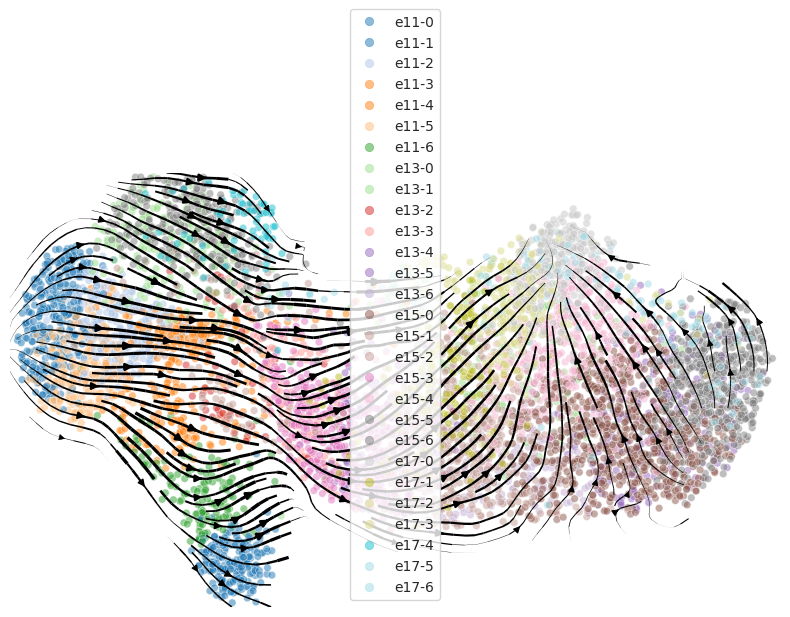

In [128]:
import itertools
velocities = scegot.calculate_cell_velocities()
scegot.plot_cell_velocity(
    velocities,
    mode="umap",
    color_points="gmm",
    cluster_names=list(itertools.chain.from_iterable(cluster_names)),
    cmap="tab20",
    # save=True,
    # save_path="./cell_velocity_pca.png"
)

In [129]:
%%time
GRNs, ridgeCVs = scegot.calculate_grns(
    selected_clusters=None,
    alpha_range=(-2, 2),
    cv=3,
    ridge_cv_fit_intercept=False,
    ridge_fit_intercept=False,
)

Calculating GRNs between each day...


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

CPU times: user 9.65 s, sys: 38.5 s, total: 48.1 s
Wall time: 1.3 s


alpha = 100.0


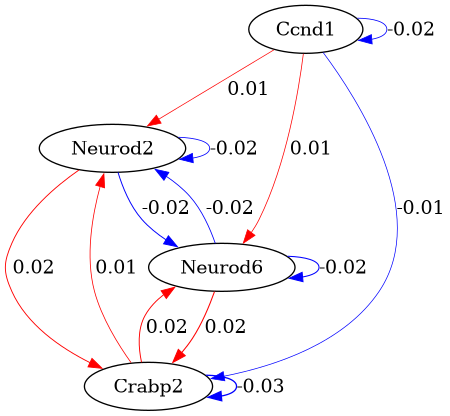

alpha = 100.0


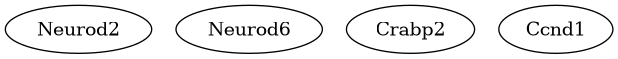

alpha = 100.0


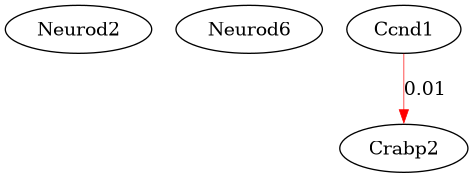

In [130]:
scegot.plot_grn_graph(
    GRNs,
    ridgeCVs,
    selected_genes,
    threshold=0.01,
    # save=True,
    # save_paths=[f"./grn_{day_name}.png" for day_name in DAY_NAMES],
    # save_format="png"
)

In [31]:
%%time
Wpotential, F_all = scegot.calculate_waddington_potential(
    n_neighbors=100,
    knn_other_params={},
)

Calculating F between each day...


100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


Applying knn ...
Computing kernel ...
CPU times: user 9.02 s, sys: 36.7 s, total: 45.7 s
Wall time: 1.87 s


In [32]:
import plotly.io as pio

scegot.plot_waddington_potential(
    Wpotential,
    mode="pca",
    gene_name=None,
    # save=True,
    # save_path="./waddington_potential_pca_potential.html"
)

In [41]:
scegot.plot_waddington_potential(
    Wpotential,
    mode="umap",
    gene_name=None,
    # save=True,
    # save_path="./waddington_potential_umap_potential.html"
)

In [33]:
scegot.plot_waddington_potential_surface(
    Wpotential,
    mode="pca",
    # save=True,
    # save_path="./waddington_potential_surface_pca.html"
)

In [34]:
scegot.plot_waddington_potential_surface(
    Wpotential,
    mode="umap",
    # save=True,
    # save_path="./waddington_potential_surface_umap.html"
)